In [15]:
import numpy as np
import scipy
import scipy.stats
import pandas as pd
import astropy.units as u
import sunpy.map
import cv2
# import skimage
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
sns.set_style("darkgrid")

import utils
import os


%matplotlib inline

Observatory,SDO
Instrument,AIA 2
Detector,AIA
Measurement,193.0 Angstrom
Wavelength,193.0 Angstrom
Observation Date,2015-12-28 03:16:41
Exposure Time,1.999619 s
Dimension,[256. 256.] pix
Coordinate System,helioprojective
Scale,[9.611424 9.611424] arcsec / pix
Reference Pixel,[127.08625031 127.05374906] pix

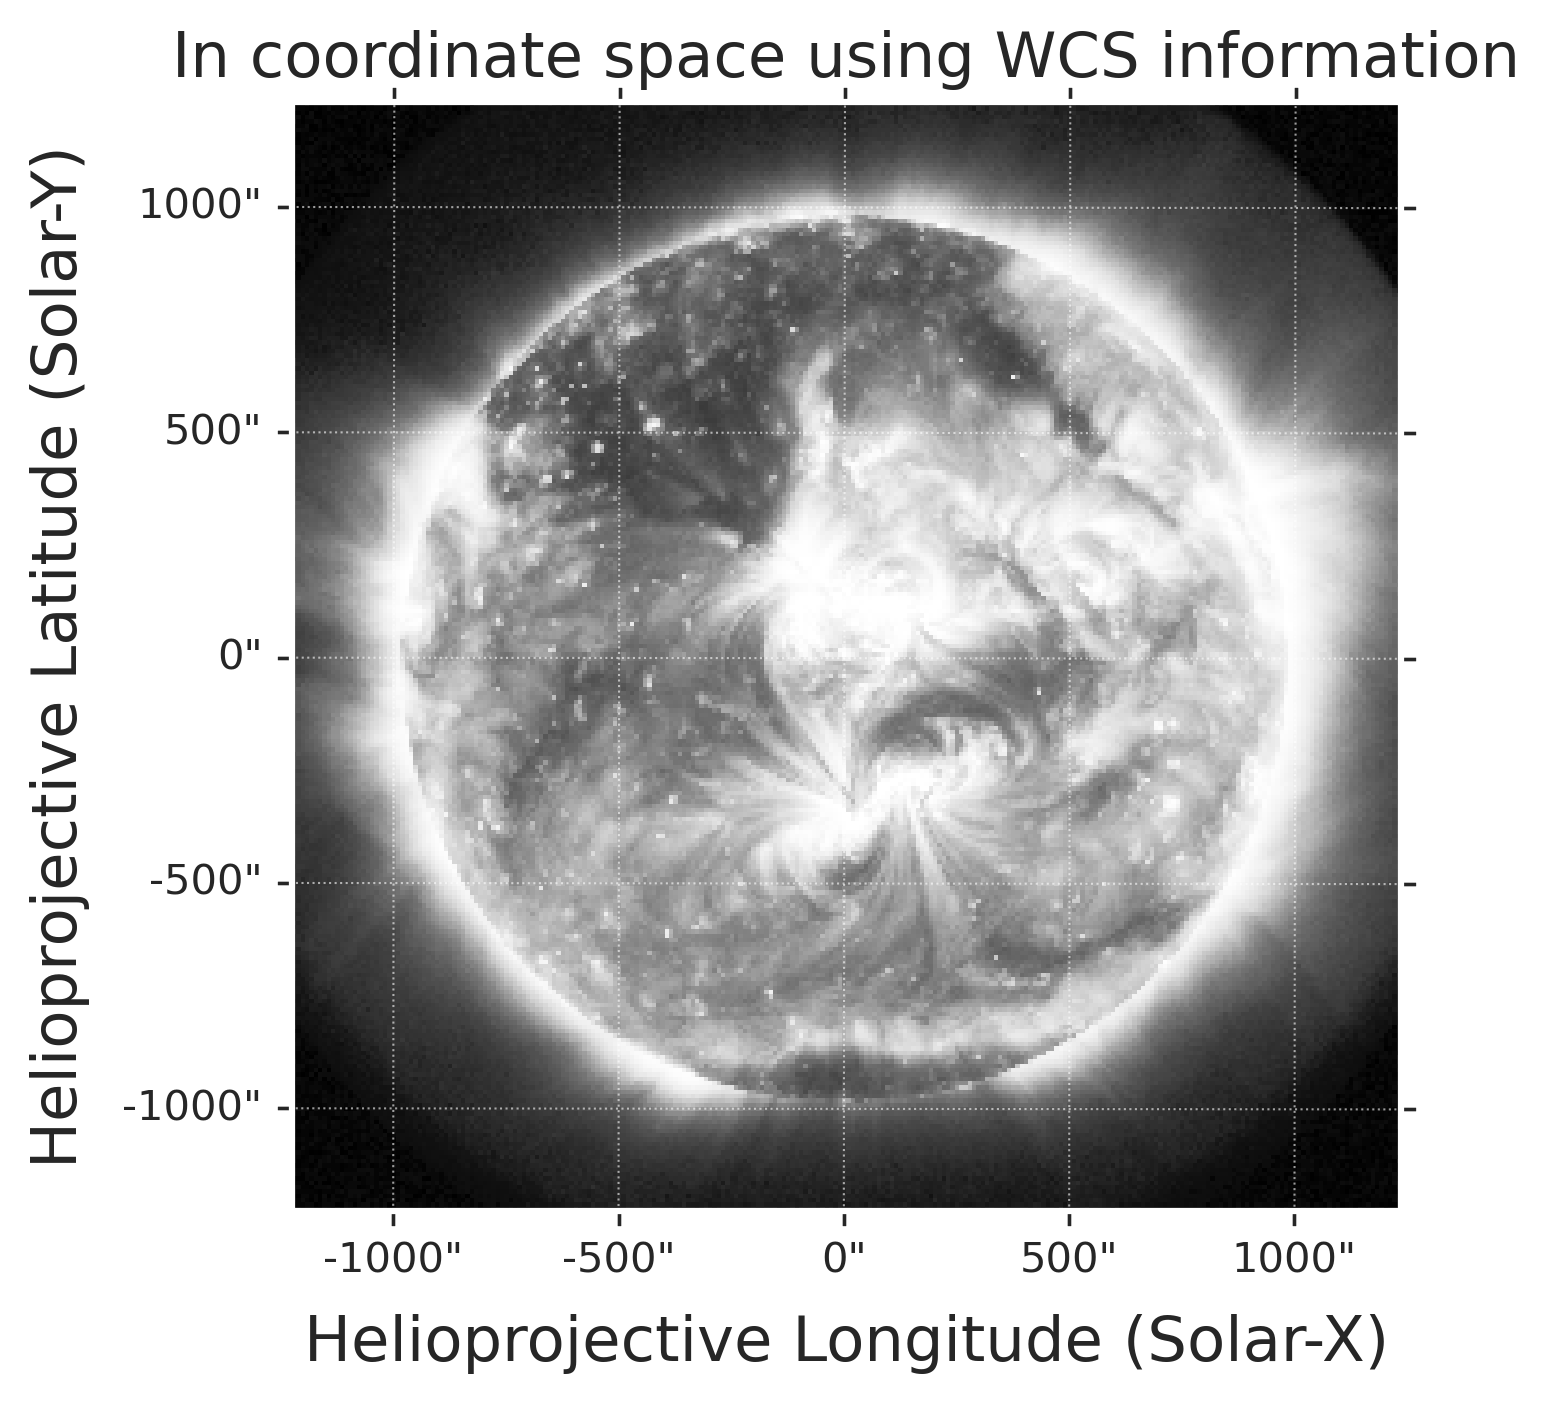
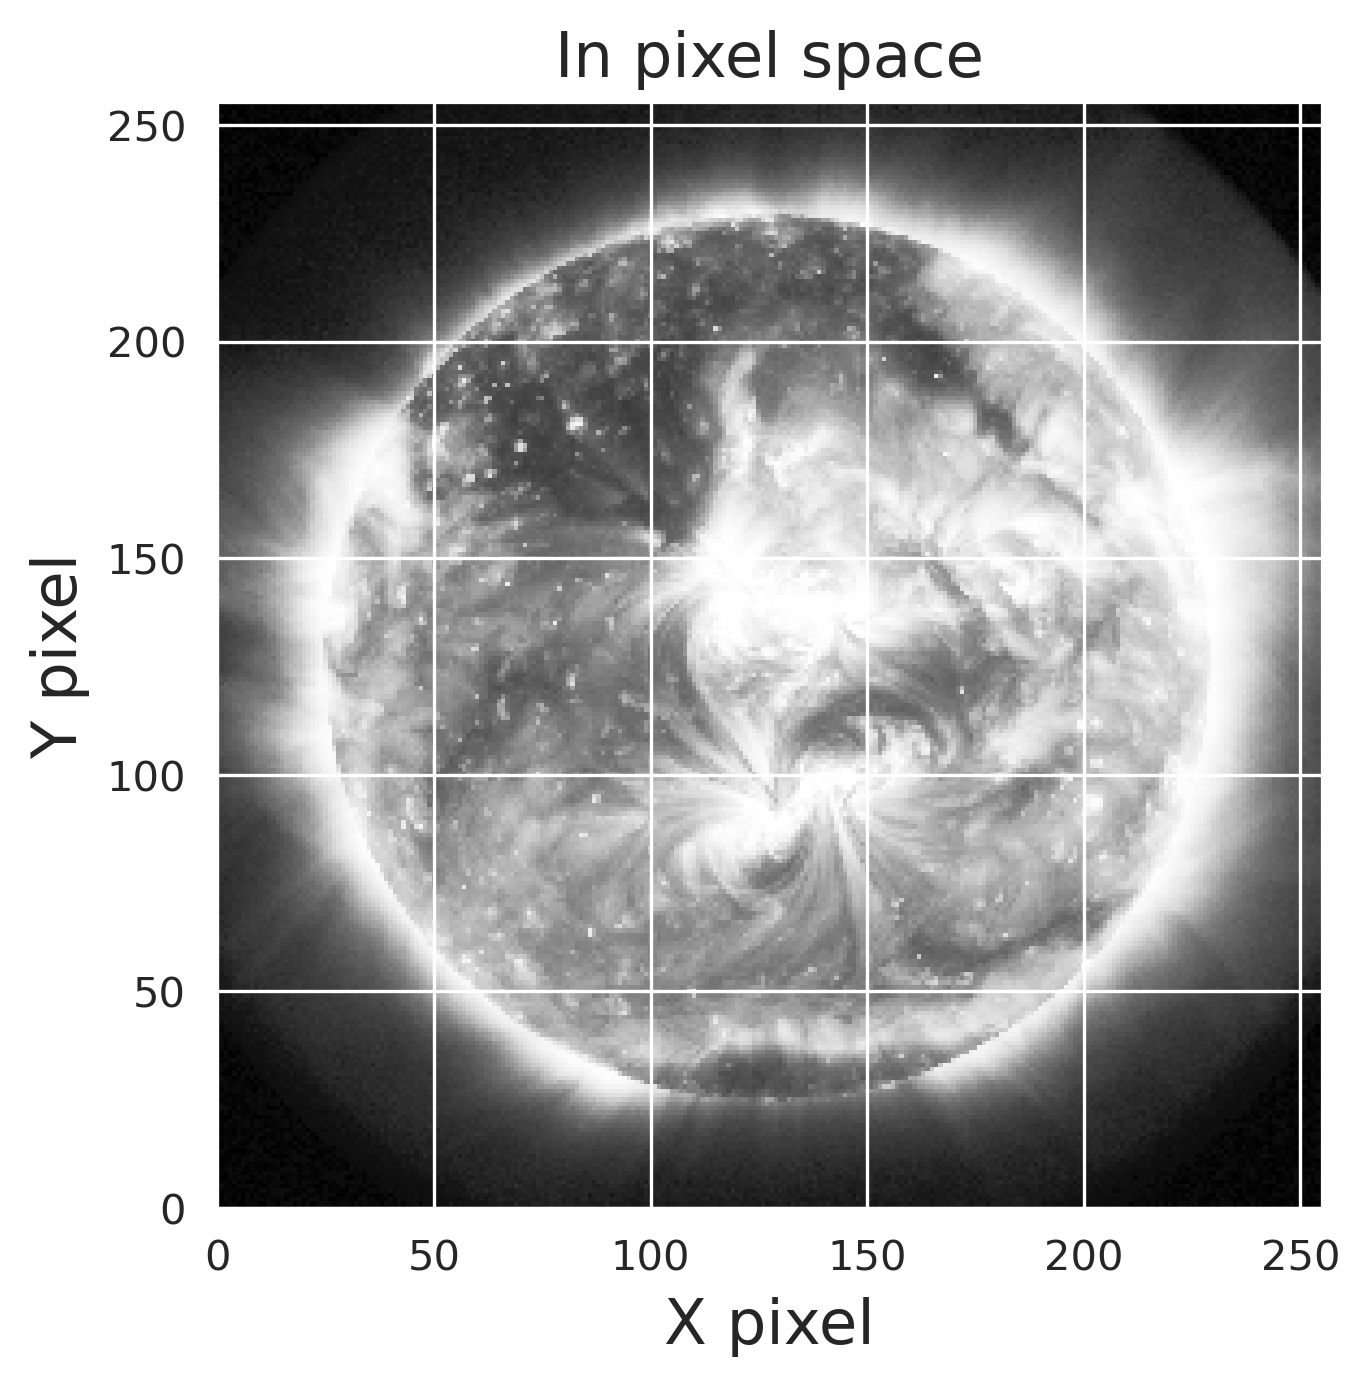
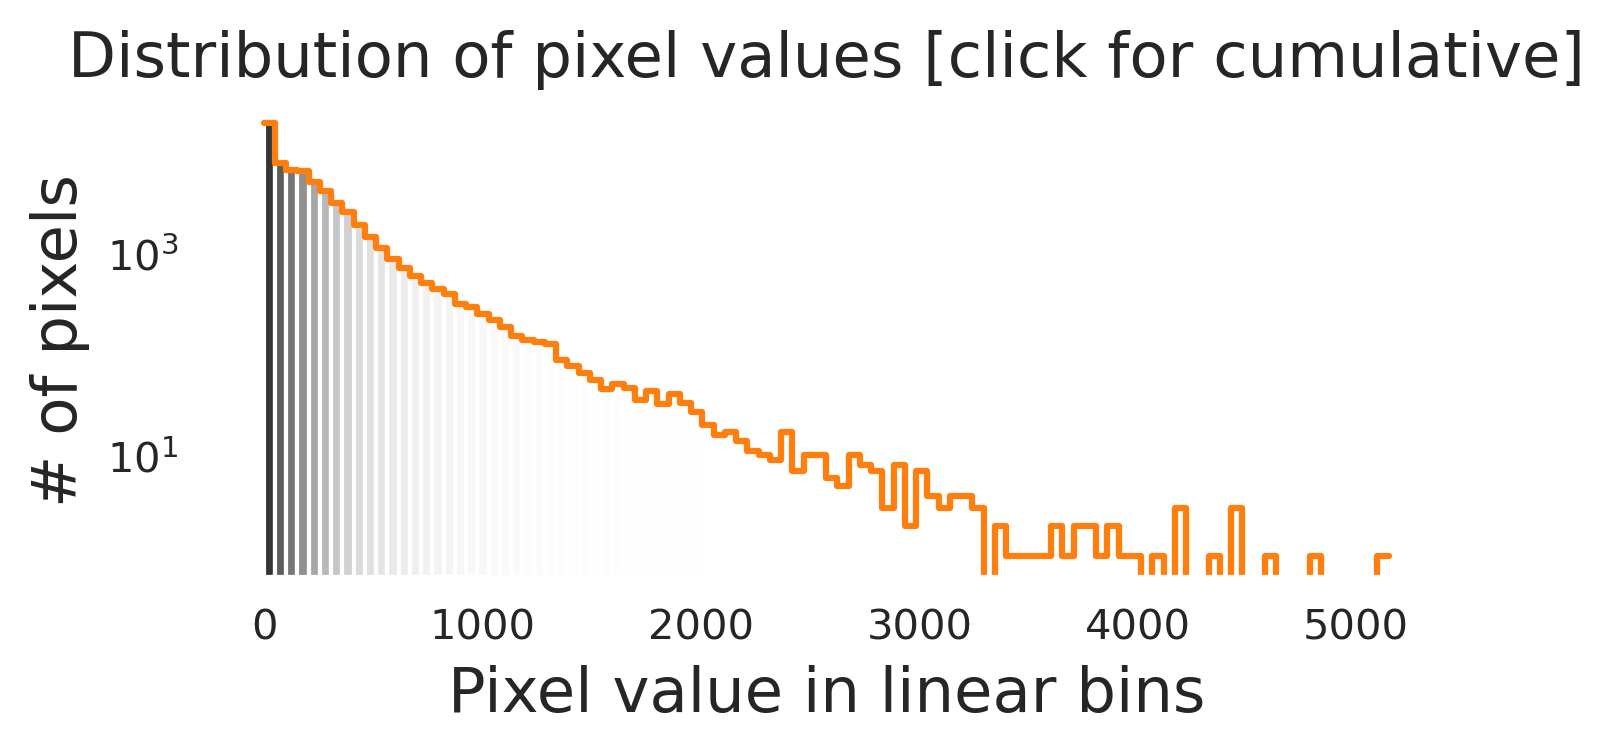
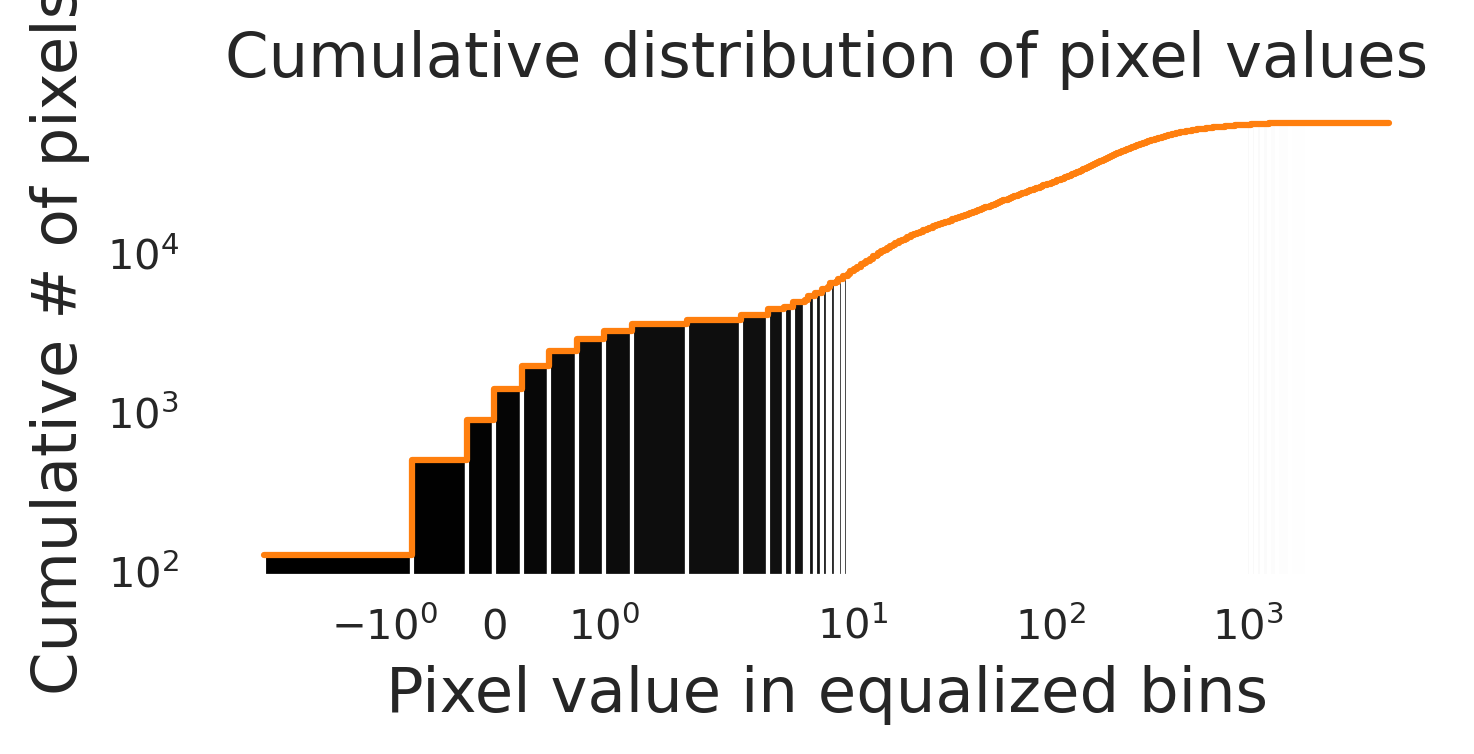

In [2]:
AIA193_2016 = sunpy.map.Map("data/aia_193A/2016*.fits")
AIA193_2016[0]

In [3]:
AIA193_2016_matrix = np.array(list(d.data for d in AIA193_2016))
AIA193_2016_matrix.shape

(2820, 256, 256)

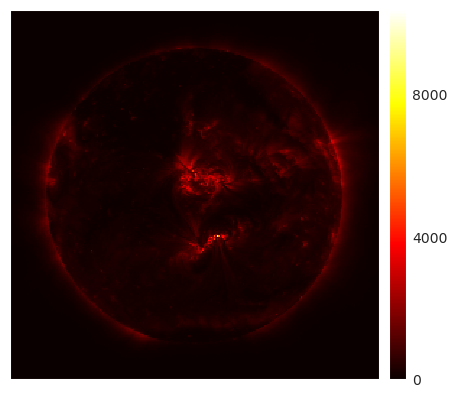

In [4]:
isns.imshow(AIA193_2016_matrix[1], cmap="hot")
plt.show()

In [5]:
print(utils.range_tuple(AIA193_2016_matrix))
print(utils.range_tuple(AIA193_2016_matrix[8]))

(-32768.0, 16383.0)
(-1.75, 6204.0)


In [6]:
min_values = AIA193_2016_matrix.min(axis=2).min(axis=1)
print(min_values.shape)

max_values = AIA193_2016_matrix.max(axis=2).max(axis=1)
max_values.shape

(2820,)


(2820,)

In [7]:
rg = max_values - min_values

rg = np.maximum(rg, 1e-4*np.ones(rg.shape)).reshape([-1,1,1])

AIA193_2016_mnorm = (AIA193_2016_matrix-min_values.reshape([-1,1,1])) / rg
utils.range_tuple(AIA193_2016_mnorm)

(0.0, 1.0)

In [8]:
AIA193_2016_bytes = np.round(AIA193_2016_mnorm*255).astype(np.uint8)
np.unique(AIA193_2016_bytes)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

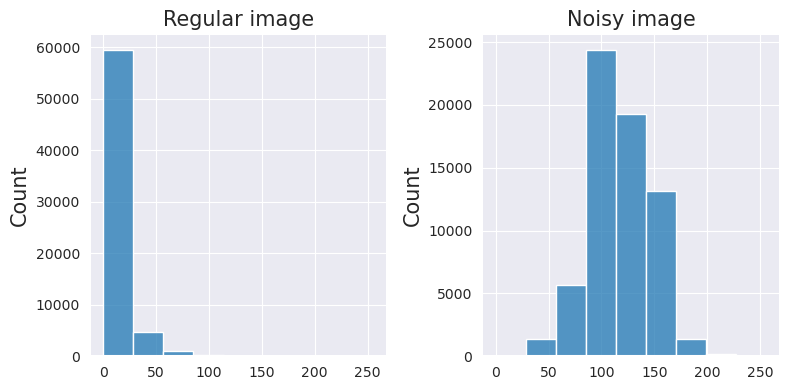

In [9]:
nbins = 10

fig, axes = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw=dict(width_ratios=[4, 4]))

sns.histplot(AIA193_2016_bytes[0].flatten(), bins=np.linspace(0,256,nbins), ax=axes[0]).set(title="Regular image")

p = sns.histplot(AIA193_2016_bytes[6].flatten(), bins=np.linspace(0,256,nbins), ax=axes[1]).set(title="Noisy image")

fig.tight_layout()

In [10]:
hist_vectors = np.array([np.histogram(i.flatten(), bins=np.linspace(0,256,nbins))[0] for i in AIA193_2016_bytes])

In [11]:
kmeans = KMeans(n_clusters=2, n_init=10)
kmeans.fit(hist_vectors/hist_vectors.max())
kmeans

KMeans(n_clusters=2)

(2475, 256, 256)
(345, 256, 256)


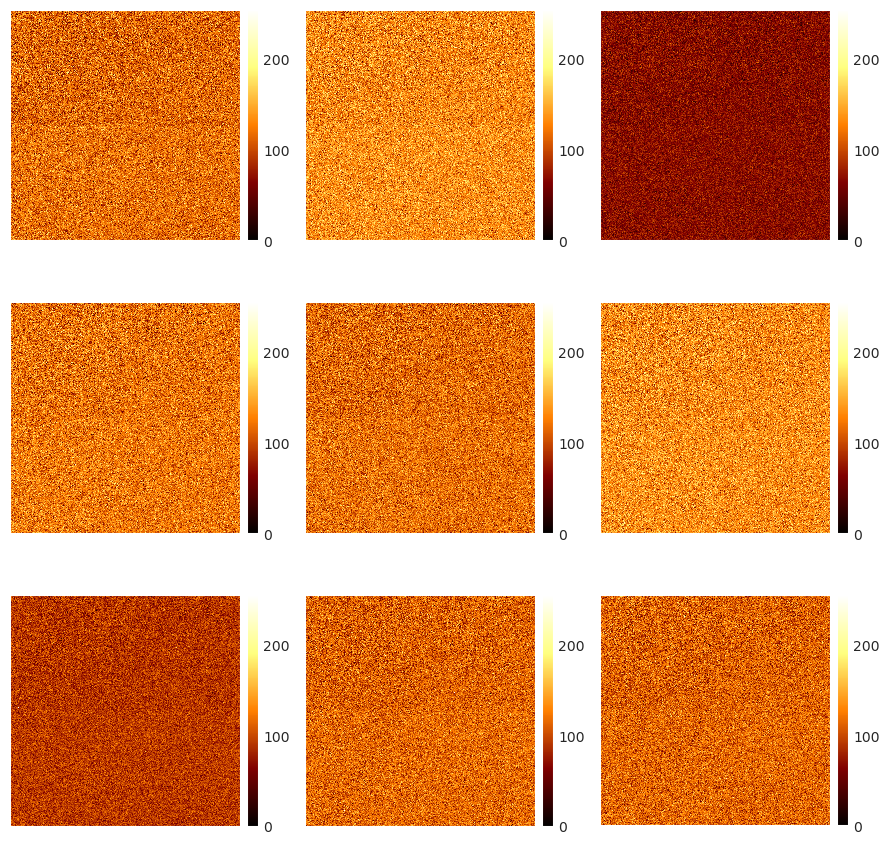

In [12]:
class1 = AIA193_2016_bytes[kmeans.labels_ == 0, :, :]
class2 = AIA193_2016_bytes[kmeans.labels_ != 0, :, :]
print(class1.shape)
print(class2.shape)
isns.ImageGrid([i for i in class2[:9]], cmap="afmhot")
plt.show()

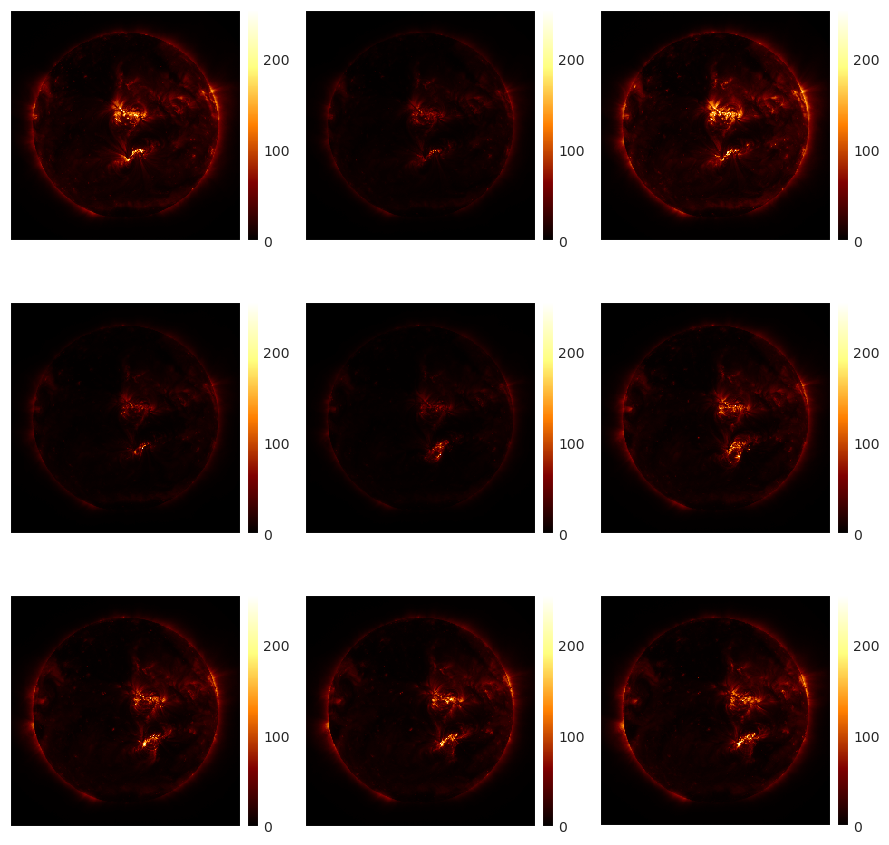

In [13]:
isns.ImageGrid([i for i in class1[:9]], cmap="afmhot")
plt.show()

In [24]:
noise_imgs = pd.DataFrame(columns=["fname"])
for idx, val in enumerate(os.listdir("data/aia_193A/")):
    print("a")
    img = sunpy.map.Map("data/aia_193A/" + val).data
    img_norm = (img-min_values.reshape([-1,1,1])) / rg
    img_bytes = np.round(img_norm*255).astype(np.uint8)
    hist_img = np.histogram(img_bytes.flatten(), bins=np.linspace(0,256,nbins))[0] 
    print("b")
    print(kmeans.predict(hist_img.reshape([1, -1])))
    
    if idx > 100:
        break

a


KeyboardInterrupt: 